In [1]:
from google.colab import files
uploaded = files.upload()   # Select air_quality_data.csv


Saving air_quality_data.csv to air_quality_data.csv


In [2]:
import pandas as pd
df = pd.read_csv("air_quality_data.csv", parse_dates=['date'])


In [3]:
!pip install xgboost lightgbm prophet


# AQI Prediction Project - EDA (Week 1)
This notebook loads the dataset, checks missing values, and creates 3 visualizations:
- AQI/PM2.5 trend over time
- Pollutant correlation heatmap
- Monthly seasonality of AQI

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset (keep dataset in ../data/raw/)
# Using the filename of the uploaded file
df = pd.read_csv("air_quality_data.csv", parse_dates=['date'])
display(df.head())

,date,city,pm2.5,pm10,no2,so2,co,o3,aqi
0,2023-01-01,Delhi,180,250,40,12,1.2,20,250
1,2023-01-02,Delhi,175,240,42,13,1.1,22,245
2,2023-01-03,Delhi,160,230,45,14,1.3,25,240
3,2023-01-04,Delhi,200,260,43,12,1.4,24,265
4,2023-01-05,Delhi,210,270,41,15,1.2,21,270


In [5]:
# Check structure and missing values
display(df.info())
display(df.isnull().sum().sort_values(ascending=False).head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    20 non-null     datetime64[ns]
 1   city    20 non-null     object        
 2   pm2.5   20 non-null     int64         
 3   pm10    20 non-null     int64         
 4   no2     20 non-null     int64         
 5   so2     20 non-null     int64         
 6   co      20 non-null     float64       
 7   o3      20 non-null     int64         
 8   aqi     20 non-null     int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 1.5+ KB


None

,0
date,0
city,0
pm2.5,0
pm10,0
no2,0
so2,0
co,0
o3,0
aqi,0


In [6]:
# Clean column names & aggregate to city level
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]
city_daily = df.groupby(['city','date']).mean().reset_index()
display(city_daily.head())

,city,date,pm2.5,pm10,no2,so2,co,o3,aqi
0,Delhi,2023-01-01,180.0,250.0,40.0,12.0,1.2,20.0,250.0
1,Delhi,2023-01-02,175.0,240.0,42.0,13.0,1.1,22.0,245.0
2,Delhi,2023-01-03,160.0,230.0,45.0,14.0,1.3,25.0,240.0
3,Delhi,2023-01-04,200.0,260.0,43.0,12.0,1.4,24.0,265.0
4,Delhi,2023-01-05,210.0,270.0,41.0,15.0,1.2,21.0,270.0


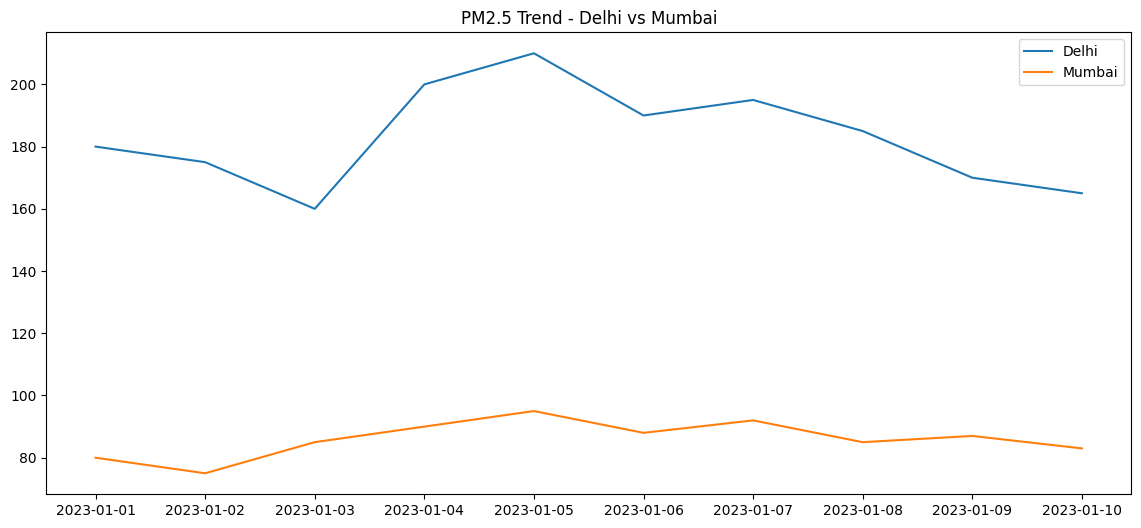

In [7]:
# Plot trend: PM2.5 in Delhi vs Mumbai
cities = ['Delhi','Mumbai']
plt.figure(figsize=(14,6))
for city in cities:
    temp = city_daily[city_daily['city'].str.lower()==city.lower()]
    plt.plot(temp['date'], temp['pm2.5'], label=city)
plt.legend()
plt.title("PM2.5 Trend - Delhi vs Mumbai")
plt.show()

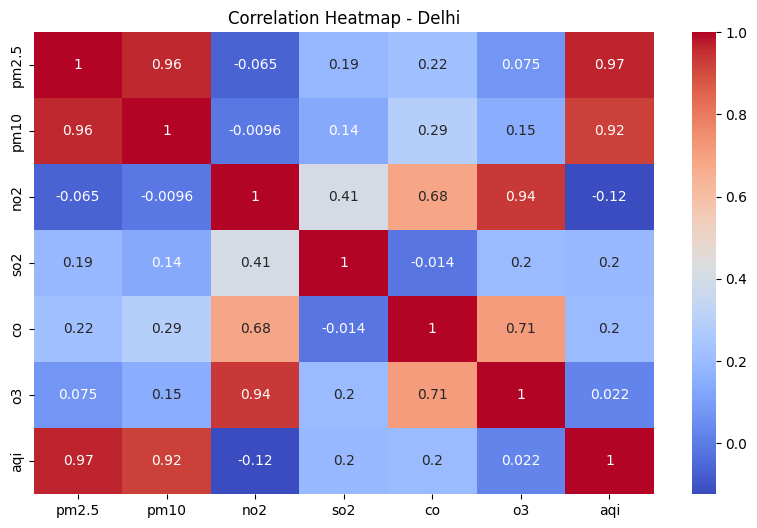

In [8]:
# Correlation heatmap for Delhi
city = 'Delhi'
temp = city_daily[city_daily['city'].str.lower()==city.lower()]
pollutants = ['pm2.5','pm10','no2','so2','co','o3','aqi']
plt.figure(figsize=(10,6))
sns.heatmap(temp[pollutants].corr(), annot=True, cmap='coolwarm')
plt.title(f"Correlation Heatmap - {city}")
plt.show()

In [11]:
# =========================
# Data Preprocessing
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Load dataset
# -------------------------
# Using the filename of the uploaded file
file_path = "air_quality_data.csv"
df = pd.read_csv(file_path, parse_dates=['date'])

print("Shape:", df.shape)
print(df.head())

# -------------------------
# 2. Handle missing values
# -------------------------
# Check missing
print("\nMissing Values:\n", df.isnull().sum())

# Option A: Fill numeric columns with median
for col in df.select_dtypes(include=[np.number]).columns:
    df[col] = df[col].fillna(df[col].median())

# Option B: Forward-fill time series (better for AQI data)
# df = df.fillna(method='ffill')

print("\nMissing after fill:\n", df.isnull().sum())

# -------------------------
# 3. Feature engineering
# -------------------------
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['season'] = df['month']%12 // 3 + 1   # 1:Winter, 2:Spring, 3:Summer, 4:Fall

print(df[['date','year','month','dayofweek','season']].head())

# -------------------------
# 4. Encode categorical variables
# -------------------------
# If dataset has city column
if 'city' in df.columns:
    df = pd.get_dummies(df, columns=['city'], drop_first=True)

# -------------------------
# 5. Scaling (normalize pollutant values)
# -------------------------
from sklearn.preprocessing import StandardScaler

num_cols = df.select_dtypes(include=[np.number]).columns.drop(['year'])  # exclude year
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("\nScaled columns preview:\n", df[num_cols].head())

# -------------------------
# 6. Train-test split
# -------------------------
from sklearn.model_selection import train_test_split

# Assume AQI is target (adjust based on dataset)
X = df.drop(['aqi','date'], axis=1) # Corrected column name to 'aqi'
y = df['aqi'] # Corrected column name to 'aqi'

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

print("\nTrain shape:", X_train.shape, " Test shape:", X_test.shape)

Shape: (20, 9)
        date   city  pm2.5  pm10  no2  so2   co  o3  aqi
0 2023-01-01  Delhi    180   250   40   12  1.2  20  250
1 2023-01-02  Delhi    175   240   42   13  1.1  22  245
2 2023-01-03  Delhi    160   230   45   14  1.3  25  240
3 2023-01-04  Delhi    200   260   43   12  1.4  24  265
4 2023-01-05  Delhi    210   270   41   15  1.2  21  270

Missing Values:
 date     0
city     0
pm2.5    0
pm10     0
no2      0
so2      0
co       0
o3       0
aqi      0
dtype: int64

Missing after fill:
 date     0
city     0
pm2.5    0
pm10     0
no2      0
so2      0
co       0
o3       0
aqi      0
dtype: int64
        date  year  month  dayofweek  season
0 2023-01-01  2023      1          6       1
1 2023-01-02  2023      1          0       1
2 2023-01-03  2023      1          1       1
3 2023-01-04  2023      1          2       1
4 2023-01-05  2023      1          3       1

Scaled columns preview:
       pm2.5      pm10       no2       so2        co        o3       aqi  \
0  0.913

/tmp/ipython-input-1150660863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['month'] = temp['date'].dt.month


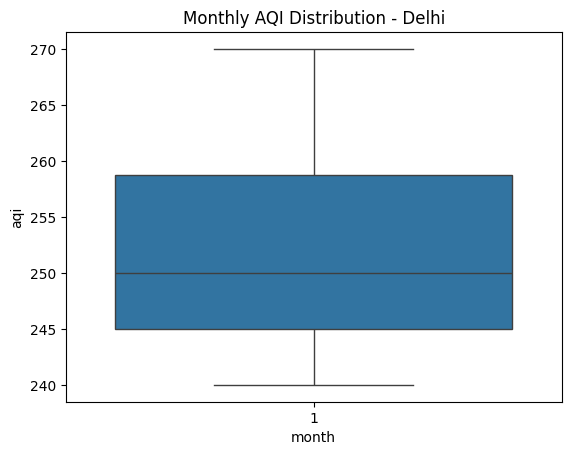

In [9]:
# Monthly seasonality of AQI
temp['month'] = temp['date'].dt.month
sns.boxplot(x='month', y='aqi', data=temp)
plt.title(f"Monthly AQI Distribution - {city}")
plt.show()

## Key Observations
- Missing values exist for some pollutants; cleaning required later.
- PM2.5 levels are higher in Delhi than Mumbai across most years.
- AQI strongly correlates with PM2.5 and PM10.
- Seasonal peaks: winter months show higher AQI values.